<a href="https://colab.research.google.com/github/khushboo0824/cognitive-assessment-/blob/main/CNN/cognitive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khushboochauhan08","key":"1f0a8cdbb234c5e6b881934f26aac3f1"}'}

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 78% 56.0M/71.5M [00:00<00:00, 146MB/s]
100% 71.5M/71.5M [00:00<00:00, 117MB/s]


In [5]:
import zipfile

dataset_path = "/content/best-alzheimer-mri-dataset-99-accuracy.zip"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/MRI_Dataset")


In [6]:
import os
os.listdir("/content/MRI_Dataset/CombinedDataset/train")
os.listdir("/content/MRI_Dataset/CombinedDataset/test")

FileNotFoundError: [Errno 2] No such file or directory: '/content/MRI_Dataset/CombinedDataset/train'

In [7]:
train_dir = "/content/MRI_Dataset/CombinedDataset/train"
test_dir = "/content/MRI_Dataset/CombinedDataset/test"


PRE-PROCESSING

In [18]:
IMG_SIZE = 128  # Ensure this is an integer
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Splitting train data into training & validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # FIXED
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # FIXED
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)



Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


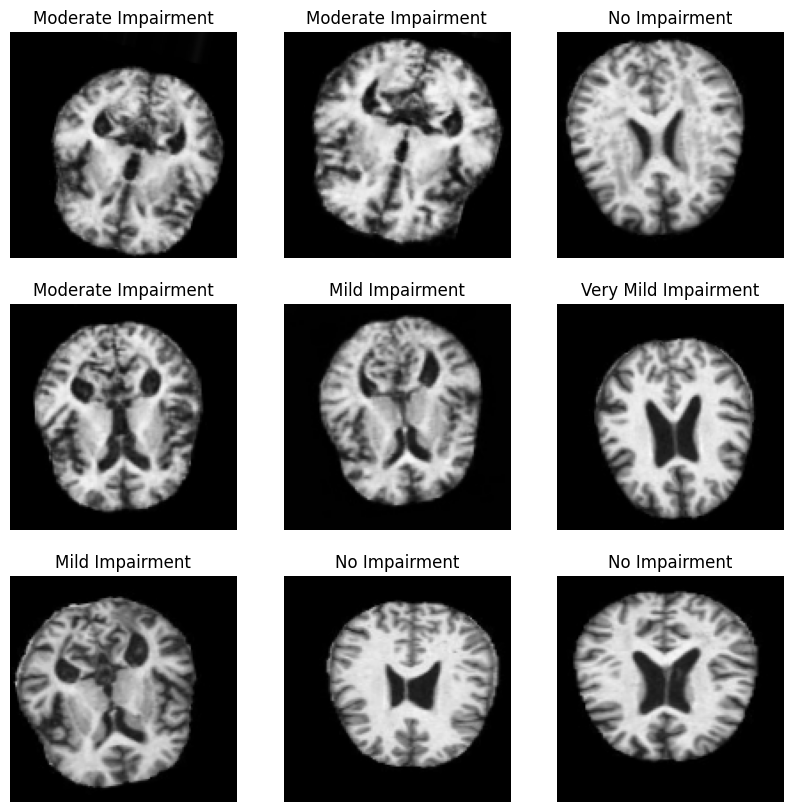

In [35]:
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Get a batch of images and labels
for i in range(min(9, len(images))):  # Ensure we don't exceed the batch size
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    if np.max(img) <= 1.0:
        img = (img * 255).astype("uint8")
    plt.imshow(img.astype("uint8"))
    label_index = np.argmax(labels[i])
    class_label = class_names[label_index]
    plt.title(class_label)
    plt.axis("off")
plt.show()

In [40]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

model.fit(train_generator,
          epochs=50,  # You can extend up to 15
          validation_data=validation_generator,
          callbacks=[early_stop])


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - accuracy: 0.5290 - loss: 1.2438 - val_accuracy: 0.2510 - val_loss: 26.9173
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 535s 4s/step - accuracy: 0.6379 - loss: 0.8936 - val_accuracy: 0.2490 - val_loss: 24.8017
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.6971 - loss: 0.7077 - val_accuracy: 0.2490 - val_loss: 11.1707
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.7358 - loss: 0.6043 - val_accuracy: 0.3384 - val_loss: 3.2858
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.7483 - loss: 0.5591 - val_accuracy: 0.4858 - val_loss: 1.2267
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - accuracy: 0.7618 - loss: 0.5250 - val_accuracy: 0.3218 - val_loss: 2.9714
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.7721 - loss: 0.4981 - val_accuracy: 0.5601 - val_loss: 0.9669
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - accuracy: 0.7821 - loss: 0.4877 - val_a

In [ ]:
model.save("mri_classification_model.h5")  # Saves the model in HDF5 format


In [ ]:
model.save('mri_model.keras')  # Saves in TensorFlow's SavedModel format


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('mri_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
model.evaluate(test_generator)


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 732ms/step - accuracy: 0.5402 - loss: 1.3865


[1.3647798299789429, 0.5379202365875244]

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 738ms/step


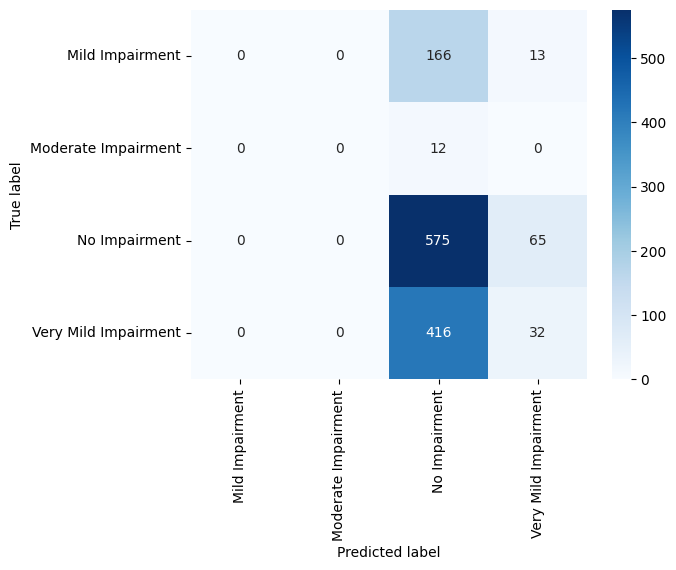

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [49]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(32,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
